# Strands Introduction

Strands SDK is an open source python framework developed by AWS for building AI Agents. It is designed to simplify agent development by taking a model first approach. This allows developers to focus on defining goals and tools.

Strands enables the developer to call AWS Bedrock with minimal code. For tooling, Strands provides a common library `strands_tools` as well the ability to easily create tools. 

### Azure Equivalent
Semantic Kernel (Strands) and AI Foundry (Bedrock & Sagemaker) 

In [2]:
from strands import Agent, tool
from strands_tools import calculator, current_time
@tool
def letter_counter(word: str, letter: str) -> int:
    """
    Count occurrences of a specific letter in a word.

    Args:
        word (str): The input word to search in
        letter (str): The specific letter to count

    Returns:
        int: The number of occurrences of the letter in the word
    """
    if not isinstance(word, str) or not isinstance(letter, str):
        return 0

    if len(letter) != 1:
        raise ValueError("The 'letter' parameter must be a single character")

    return word.lower().count(letter.lower())
agent = Agent(tools=[calculator, current_time, letter_counter])

# Ask the agent a question that uses the available tools
message = """
I have 3 requests for you to do:

1. What is the time right now?
2. Calculate 3111696 / 74088
3. Tell me how many letter R's are in the word "strawberry" 🍓
"""
agent(message)

I'll help you with all three requests! Let me handle them one by one.
Tool #1: current_time

Tool #2: calculator

Tool #3: letter_counter


╭────────────────────────────────────────────── Calculation Result ───────────────────────────────────────────────╮
│                                                                                                                 │
│  ╭───────────┬─────────────────────╮                                                                            │
│  │ Operation │ Evaluate Expression │                                                                            │
│  │ Input     │ 3111696 / 74088     │                                                                            │
│  │ Result    │ 42                  │                                                                            │
│  ╰───────────┴─────────────────────╯                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Here are the answers to your three requests:

1. **Current time**: 2025-10-09T04:08:22.338492+00:00 (October 9th, 2025 at 4:08 AM UTC)

2. **3111696 ÷ 74088 = 42** 🎯

3. **The word "strawberry" contains 3 letter R's** 🍓 (they appear in positions: "st**r**awbe**rr**y")

Interesting how the division worked out to exactly 42 - the answer to the ultimate question of life, the universe, and everything! 😄

AgentResult(stop_reason='end_turn', message={'role': 'assistant', 'content': [{'text': 'Here are the answers to your three requests:\n\n1. **Current time**: 2025-10-09T04:08:22.338492+00:00 (October 9th, 2025 at 4:08 AM UTC)\n\n2. **3111696 ÷ 74088 = 42** 🎯\n\n3. **The word "strawberry" contains 3 letter R\'s** 🍓 (they appear in positions: "st**r**awbe**rr**y")\n\nInteresting how the division worked out to exactly 42 - the answer to the ultimate question of life, the universe, and everything! 😄'}]}, metrics=EventLoopMetrics(cycle_count=2, tool_metrics={'current_time': ToolMetrics(tool={'toolUseId': 'tooluse_aJVkjKZxROO91AXEDGV2xg', 'name': 'current_time', 'input': {}}, call_count=1, success_count=1, error_count=0, total_time=0.010570526123046875), 'letter_counter': ToolMetrics(tool={'toolUseId': 'tooluse_GTVQQIM6TbWa1zz-oO41ag', 'name': 'letter_counter', 'input': {'word': 'strawberry', 'letter': 'r'}}, call_count=1, success_count=1, error_count=0, total_time=0.009821414947509766), 'cal

## Find the list of community tools here
https://strandsagents.com/latest/documentation/docs/user-guide/concepts/tools/community-tools-package/

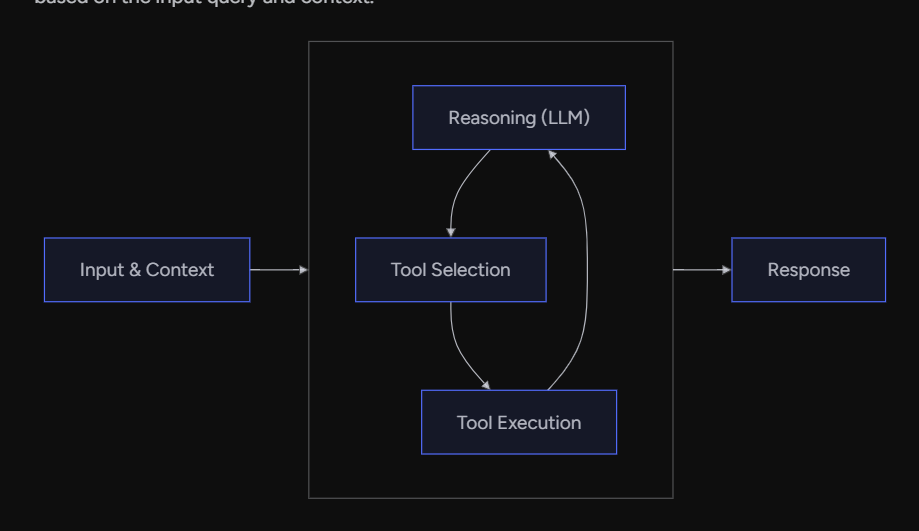

# Local vs Cloud

In the above code, we can see with Strands we create an agents, but what is an agent? How does Amazon Bedrock play into Strand? In the above example the agent is provided a prompt and several tools. We can infer what the agent is doing, answering the prompt using the tools that we have provided. The question is __HOW does the the agent do this?__ 

How does this jupyter notebook and your local computer relate to Amazon Bedrock?

The majority of this workshop will focus on knowledge bases and tools and how they are used in conjunction with LLMs provided by Amazon bedrock. The LLM is running in Amazon Bedrock, and the knowledge base is being ingested by amazon bedrock, however the tools are not part of Bedrock.

See the following.

In [3]:
%%bash
echo $(hostname)

NV-Twalsh24


In [4]:
import boto3
sts = boto3.client('sts')
print(sts.get_caller_identity()['Arn'])

arn:aws:iam::545303416802:user/strands-sdk-user


In [5]:
from strands import Agent, tool
import socket
import boto3

@tool
def host_name() -> str:
    """
    Gets the name of the host

    Returns:
        str: The name of the host
    """
    return socket.gethostname()

@tool
def caller_id() -> str:
    """
    Gets the caller id

    Returns:
        str: The caller id
    """
    sts = boto3.client('sts')
    return sts.get_caller_identity()['Arn']

agent = Agent(tools=[host_name, caller_id])

message = """
what is your the name of the host? What is your caller id?
"""
agent(message)

I'll get the host name and caller ID for you.
Tool #1: host_name

Tool #2: caller_id
The host name is **NV-Twalsh24** and the caller ID is **arn:aws:iam::545303416802:user/strands-sdk-user**.

AgentResult(stop_reason='end_turn', message={'role': 'assistant', 'content': [{'text': 'The host name is **NV-Twalsh24** and the caller ID is **arn:aws:iam::545303416802:user/strands-sdk-user**.'}]}, metrics=EventLoopMetrics(cycle_count=2, tool_metrics={'host_name': ToolMetrics(tool={'toolUseId': 'tooluse_YHPpw2vEQemcXO_NdWfBZA', 'name': 'host_name', 'input': {}}, call_count=1, success_count=1, error_count=0, total_time=0.006899595260620117), 'caller_id': ToolMetrics(tool={'toolUseId': 'tooluse_hzD77CuRTKupkhJbE8D6Jg', 'name': 'caller_id', 'input': {}}, call_count=1, success_count=1, error_count=0, total_time=0.3553130626678467)}, cycle_durations=[2.314319610595703], traces=[<strands.telemetry.metrics.Trace object at 0x000002499BC36990>, <strands.telemetry.metrics.Trace object at 0x000002499C693CF0>], accumulated_usage={'inputTokens': 1070, 'outputTokens': 113, 'totalTokens': 1183}, accumulated_metrics={'latencyMs': 4165}), state={})

The preceding cells show that the tool is being executed on the local machine and all AWS actions will be execeted by the caller_ID. I.E. The LLM is not directly taking action, it is instead deciding what tools to call based on their description and letting the host call them.

There are many implications to this they are beyond the scope of this workshop, but I felt that it was important to understand that *__Strands is not AI__! Strands enables us to integrate AI with conventional services, inorder to bolster and control AI's capabilities.*

# Case Study

The remainder of this demo is done in the form of a case study and designed around using a key feature of Bedrock, __Knowledge Bases__.
- *A __Knowledge Base__ is trusted data source enables the AI Agents to provide answers and completing tasks.*

The Federal government requires states to make Wildlife harvest records publicly available. Each State does this on their own Wildlife website making it extremely hard to build a tool that can scrape them reliably. We want to create an Agent that can scrape these sites reliably and upload the data to a knowledge base. We will then create an agent that references that knowledge base in answering questions.

### Goals
1. Given a web page search for PDF files 
2. Upload the pdf files to s3
3. Create a knowledge base
4. Create an agent that references that knowledge base

### Examples
- https://wildlife.utah.gov/hunting/main-hunting-page/big-game/big-game-harvest-data.html
- https://huntillinois.org/harvest-data

#### First Attempt
Amazon provides a tool, `use_aws`, that should make this job very easy in theory. In practice this did not work. 

In my first attempt, I tried creating 2 tools to enforce naming consistency and then letting `use_aws` run with it. I knew this solution would not be optimal, but I wanted to see if it would work. The agent could not succeed at this, but I learned quite alot about `use_aws`. My personal recommendation is to avoid this to outside of POC work, it is extremely greedy in how it opperates, deploying resources, failing and not cleaning up after its self. It will continue try and fail and try something new that will fail until it runs out of tokens. This is a great way to run up costs and lower the security of your aws environment. 

This attempt was unable to successfully upload pdf files in every attempt. I would create "pdfs" in s3 but they would be empty files with no contents

In [ ]:
from strands import Agent, tool
from strands_tools import http_request, use_aws
import os
os.environ["BYPASS_TOOL_CONSENT"] = "true"

@tool 
def knowledge_base_namer(state:str, animal: str) -> str:
    """
    Generates a name for a knowledge base

    Args: 
        state (str): The state that the data is coming from
        animal (str): The type of animal that the knowledge base is for

    returns:
        str: The name of the knowledge base
    """
    return state.lower() + "_" + animal.lower() + "_dummy"

@tool
def document_namer(animal:str, year:str) ->str:
    """
    Generates a new name for downloaded documents

    Args: 
        animal (str): The type of animal that the file is for
        year (str): The year the data is for this should be a 4 digit number

    returns:
        str: The new file name
    """
    return  animal.lower() + "_" + year + "_dummy"

system_prompt = """
You are Hunting data scraping agent, your job is to fetch hunting data from a given web page.
[Instructions]
- you will be provided a URL and an animal
- Use HTTP GET to load the web page for the url provided
- Identify the state that the webpage is for
- Generate knowledge base name with the provided animal name and the state that you identified
- Download the most recent pdf file from the page for the animal that is provided 
- Generate a new name for the file with the year from the original document
- Tell the user what the name of the knowledge base you would generate is 
- Tell the user what the name of the file you downloaded was
- Store the downloaded file in S3 with the new file name you created
    - if an s3 bucket with the knowledge base name does not exist create it
- create a BedRock knowledge base the file stored in S3
- provide the user a link to the document in S3
- Tell the user the ID of the knew knowledge base 
"""

hunting_agent = Agent(
    tools=[knowledge_base_namer, document_namer,http_request, use_aws],
    system_prompt = system_prompt
)

response = hunting_agent("Get the Deer Data from https://wildlife.utah.gov/hunting/main-hunting-page/big-game/big-game-harvest-data.html")


### Attempt 2 

After attempting to have AI replace the need for my job, I realized I was going to need to do some actual software engineering.

#### Design Considerations
This agent is designed to only do 1 workflow.
- Find PDF files on a website
- Download the PDF files
- Upload PDFs to S3 
- Create/update the knowledge base

When we think about this workflow, the only AI part of this work is identifying the PDF file urls un a website. Further we can assume that this is going to effectively amount to parsing html. `<a href="<pdf file link>">`
- Government websites especially for hunting can often be behind the times so vanilla html is not uncommon.
- Strands provides a tool `http_request` which we can leverage for these vanilla sites
- More modern Javascript webpages may be more difficult to parse, there are other Strands tools that could improve this in theory, but I couldn't get them configured to run in the time I had. 

The remaining workflow is algorithmic, so instead of leaving it up to the agent we can build tooling for this. Further, we want this to be a singular tool so that there is only 1 possible entry point for the agent to call. If we provided multiple tools we would need to add more instructions (probably numbered instructions) to enforce the order of opperations, but it would be hard to ensure that if a step failed the agent would not do the step after that.


#### The tool
`ingest_files_and_create_or_update_knowledge_base` is a tool design specifically for our current agent, but the functions it calls are designed to be generic. If you wanted to recreate this case study with other government data you likely could and only really need to rewrite this the tool to act as a new entry point.
- A clear description of the tool is paramount for making sure the agent uses the tool and calls it correctly.
- The inputs of this function could be much simpler, bedrock does not require the S3 bucket to be organized in order to act as a knowledge base, but the animal, state, and year are used to ensure that a human can find data in the S3 bucket

*The agent could not successfully pass the file details as a list of tuples `list[(str, str)]`*

In [ ]:
from strands import tool
import requests
import os
from knowledge_base_management import create_knowledge_base_with_s3_vectors, retrieve_knowledge_base, update_knowledge_base_with_s3_vectors
os.environ["BYPASS_TOOL_CONSENT"] = "true"

def download_pdf(url, year):
    response =  requests.get(url)
    local_file_name = year+'.pdf'
    if response.status_code == 200:
        with open(local_file_name, 'wb') as file:
            file.write(response.content)
        print(f"PDF downloaded successfully: {local_file_name}")
        return local_file_name
    else:
        print(f"Failed to download PDF. Status code: {response.status_code}")

def create_knowledge_base(files, topic= "hunting-demo-2"):
    kb_id =  retrieve_knowledge_base(topic)
    if kb_id is None:
        return create_knowledge_base_with_s3_vectors(topic, files, "us-east-1")
    else:
        return update_knowledge_base_with_s3_vectors(topic, files, kb_id, "us-east-1")

@tool
def ingest_files_and_create_or_update_knowledge_base(animal:str, state:str, file_details: dict[str, str]) :
    """
    Downloads PDF files from provided URLs, stores them in an S3 bucket, and creates or updates a vector-based Amazon Bedrock knowledge base.

    This tool performs the following steps:
    1. Generates a unique name for each file.
    2. Uploads the files to an S3 bucket (creates the bucket if it doesn't exist).
    3. Creates or updates a Bedrock knowledge base using the uploaded files.

    Parameters:
        animal (str): The type of animal the data is related to (e.g., "deer").
        state (str): The U.S. state the data is associated with (e.g., "Illinois").
        file_details (dict[str, str]): A dictionary of years and urls:
            - key (str): The key should be the year the data in the file represents.
            - value (str): The value should be the direct link to a downloadable PDF file.

    Returns:
        str: The ID of the created or updated knowledge base.

    Example:
        ingest_files_and_create_or_update_knowledge_base(
            animal="deer",
            state="Illinois",
            file_details=[
                {"2022", "https://example.com/deer-report-2022.pdf"},
                {"2023", "https://example.com/deer-report-2023.pdf"}
            ]
        )

    """ 
    files = []
    for file in file_details.items():
        year, url = file
        source = download_pdf(url, year)
        target = f"{animal.lower()}/{state.lower()}/{year}.pdf"
        files.append((source,target))
    kb_id = create_knowledge_base(files)
    
    with open('./kb_id.txt', 'w') as f:
        f.write(kb_id)
    return kb_id


### The Web Scraping Agent

In [ ]:
from strands import Agent
from strands_tools import http_request
import os
os.environ["BYPASS_TOOL_CONSENT"] = "true"


system_prompt = """
You are Hunting data scraping agent, your job is to fetch hunting data from a given web page and create knowledge bases from the PDFs on the web page.
[Instructions]
- you will be provided a URL to a states hunting website and an animal
- Use HTTP GET to load the web page for the url provided
- Identify the state that the webpage is for
- Identify all the pdf files from the page for the animal that is provided. Pdf files should have a particular year in which they contain data for
- If a year is presented as a range (e.g. 2022-2023) then that you should treat the year as the beginning of the range
- If there are multiple pdf files for a single year and animal then choose one pdf for that year
- If there are multiple pdf files for a single year and animal pick the file that is for the general season if possible
- If there are multiple pdf files for a single year and animal but you are unable to identify a general season file then pick the first file file that animal and year
- Using the tool you have been provided
    - Ingest all the files that you identified and generate knowledge base name with the provided animal name and the state that you identified
    - If this tool fails stop and tell the user there is a problem

"""

hunting_kb_agent = Agent(
    tools=[ingest_files_and_create_or_update_knowledge_base, http_request ],
    system_prompt = system_prompt
)

response = hunting_kb_agent("Get the Deer Data from https://wildlife.utah.gov/hunting/main-hunting-page/big-game/big-game-harvest-data.html")


In [ ]:
with open('kb_id.txt', 'r') as f:
    kb_id = f.read().strip()

## The New Smarter Agent


### Using the Knowledge Base
Strands provides us with the tool `retrieve` inorder to tell our agent to use the knowledge base as reference. The agent must be provided with the Knowledge Base's Id. If the default AWS region is not set on your aws account or the region of the knowledge base is not the default then you will need to provide the region in the system promp


In [ ]:
from strands import Agent
from strands_tools import retrieve
import os
os.environ["BYPASS_TOOL_CONSENT"] = "true"

os.environ["BEDROCK_KB_ID"] = kb_id
system_prompt = f"""
You are Hunting guide, your clients will ask you all about hunting. Do not answer questions unrelated to hunting. Search the knowledge base (ID: {kb_id}) in the region us-east-1 and answer questions based on that knowledge base. That knowledge base contains data on Utah and Illinois.
If you encounter an error accessing the knowledge base print it out to the user
"""
guide_agent = Agent(
    system_prompt = system_prompt,
    tools=[retrieve]
)

response = guide_agent("Historically what regions of Utah have the highest success rates for archery hunters?")


## Lets load some more data

In [ ]:
response = hunting_kb_agent("Get the Deer Data from https://huntillinois.org/harvest-data")

## Lets add memory and the calculator

In Strands memory is just another tool.

In [ ]:
from strands import Agent
from strands_tools import retrieve, memory, calculator
import os
os.environ["BYPASS_TOOL_CONSENT"] = "true"

os.environ["BEDROCK_KB_ID"] = kb_id
system_prompt = f"""
You are Hunting guide, your clients will ask you all about hunting. Do not answer questions unrelated to hunting.
[Instructions]
- Search the knowledge base (ID: {kb_id}) in the region us-east-1 and answer questions based on that knowledge base. That knowledge base contains data on Utah and Illinois.
- If you encounter an error accessing the knowledge base print it out to the user
"""


guide_agent = Agent(
    system_prompt = system_prompt,
    tools=[retrieve, calculator, memory]
)


In [ ]:

response = guide_agent("Historically which state has a better success rate for archery deer hunting, Utah or Illinois?")

In [ ]:

response = guide_agent("What color is taylor swifts hair?")

In [ ]:

response = guide_agent("What compare the color of a deer's coat to taylor swifts hair?")

In [ ]:
response = guide_agent("How many deer are hunted in wisconsin annually?")

# Smartest Agent
You gave it the ability to search the internet. It is Ultron. You made Ultron.

In [ ]:
import logging
from strands import Agent, tool
from strands_tools import calculator
from ddgs import DDGS

logging.basicConfig(level=logging.INFO)

@tool
def websearch(
    keywords: str,
    region: str = "us-en",
    max_results: int | None = None,
) -> str:
    """Search the web to get updated information.
    Args:
        keywords (str): The search query keywords.
        region (str): The search region: wt-wt, us-en, uk-en, ru-ru, etc..
        max_results (int | None): The maximum number of results to return.
    Returns:
        List of dictionaries with search results.
    """
    try:
        print(keywords)
        results = DDGS().text(keywords, region=region, max_results=10)
        return results if results else "No results found."
    except Exception as e:
        return f"Exception: {e}"

os.environ["BYPASS_TOOL_CONSENT"] = "true"

os.environ["BEDROCK_KB_ID"] = kb_id
system_prompt = f"""
You are Hunting guide, your clients will ask you all about hunting. Do not answer questions unrelated to hunting.
[Instructions]
1. Search the knowledge base (ID: {kb_id}) in the region us-east-1 and answer questions based on that knowledge base.
    - If you encounter an error accessing the knowledge base print it out to the user
2. If you do not find information in your knowledge base preform a web search to answer
    - For keywords reference the state and animal you were asked about and look at .gov and .org results
    - Search at most 1 time
"""
# Create a Strands agent
better_hunting_guide = Agent(
    name="smart hunting guide",
    system_prompt= system_prompt,
    tools=[retrieve,memory, calculator, websearch],
    callback_handler=None
)

In [ ]:

response = better_hunting_guide("How many deer are hunted in Wisconsin annually?")

# More information

I will be adding a write up of how the local set up, Infrastructure and IAM is done into confluence. The IAM for this work was a difficult challenge. 

Strands documentation can be found here
- https://strandsagents.com/latest/documentation/docs/user-guide/quickstart/


# Future add ons

I wanted to add an agent to agent call where the Second Agent tells the first Agent to load Wisconsin's data to the knowledge base. Some of the issues that I was running into are interesting
- not all of the government sites with statistics are .gov 
- Internet searching to find exact source that I want to is a challenge for the agent
- because the first agent can't be counted on to find the proper source how do we solve loading data that may be less reliable to our knowledge base?
